# Personalized learning System Using Reinforcement learning For Chemical Engineers.

## Problem Definition and Objective :

Personalized learning aims to adapt educational content to individual learners based on their performance, preferences, and learning pace. Traditional one-size-fits-all teaching methods often fail to address diverse student needs. This project proposes an AI-driven personalized learning system that dynamically recommends learning content and questions to students.

The system leverages machine learning, reinforcement learning, and natural language processing to analyze student behavior and continuously improve learning recommendations.

For chemical Engineering, due to its limited exposure to AI and RL become one of the main concern solved by this project.

## Data Understanding and Preparation :
As for chemical Engineerig no particular dataset is present by 3 questions of Easy, medium, and Hard standard 1050 questionswith answer and concept are generated by different combination and save it to "Question_Bank.csv" which is further used as a dataset.

## Model

### Hybrid AI Approach combining multiple techniques:

* Machine Learning (ML)
* Feature extraction from student performance data
* Difficulty estimation and learning-progress tracking
* Deep Learning (DL)
* Deep Q-Network (DQN) for adaptive decision-making
* Neural networks to approximate the action-value function
* Natural Language Processing (NLP)
* Text embedding models (e.g., Sentence-Transformers / MiniLM)
* Semantic similarity between questions, concepts, and student responses
* Reinforcement Learning (RL)
* Core personalization engine
* Learns optimal learning paths through interaction with students
* LLM (Local / Pretrained, Non-API) For Question generation and Answer explanation and step-by-step solution generation

### Archetecture
Student Interaction ->
State Representation ->
RL Agent (DQN) ->
Action Selection ->
Content Delivery ->
Student Feedback ->
Reward Computation ->
Policy Update.

### Archetecture Description :

1. Input Layer (Student Data)
* Quiz scores
* Time taken per question
* Number of attempts
* Topic mastery level
* Historical learning path

2. State Representation

* The student’s current learning condition is encoded as a state vector, including:
Knowledge mastery per topic,Recent performance trend, Difficulty tolerance, Engagement indicators

3. Reinforcement Learning Agent
* Algorithm: Deep Q-Network (DQN)
* Policy Network: Fully connected neural network
* Exploration Strategy: ε-greedy or Boltzmann exploration

State → Q-Values → Action

4. Action Space

The agent selects one of the following:

Increase difficulty, Decrease difficulty, Revise previous topic, Introduce new topic, Generate practice questions, Explain/remedial content
5. NLP & LLM Module

Converts questions and answers into embeddings

Generates:
* Concept-aligned questions
* Natural-language explanations
* Ensures semantic alignment between student level and content
6. Reward Function

Rewards are computed based on:
* Improvement in student accuracy
* Reduction in time per question
* Consistency in correct responses
* Engagement retention

7. Learning Loop

* Experience stored in replay buffer
* Mini-batch training
* Target network stabilization
* Model checkpoints saved for offline reuse

### Justification of Design Choices

Why Reinforcement Learning?

* Personalization is a sequential decision problem

* RL adapts dynamically rather than relying on static rules

* Learns optimal teaching strategies over time

Why Deep Q-Network (DQN)?

* Handles large and continuous state spaces

* Stable and well-suited for educational environments

* Efficient learning from sparse rewards

Why NLP & Embeddings?

* Enables semantic understanding of questions and answers

* Allows concept-based rather than keyword-based learning

* Improves relevance and personalization accuracy

Why Hybrid Architecture?

Requirement
* Adaptivity ::	Reinforcement Learning
* Understanding Text ::	NLP
* Decision Making::	Deep Learning
* Content Generation ::	LLM
* Scalability ::	Modular Pipeline

Why No External APIs?

* Ensures offline deployment
* Reduces cost
* Improves data privacy
* Suitable for academic and institutional use


# CORE IMPLEMENTATION

In [ ]:
#CELL 1 : Importing Dependencies
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from collections import deque
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


In [ ]:
#CELL 2 : Generating and saving sample questions
BASE_QUESTIONS = [
    ("easy",
     "Which term is zero in steady-state mass balance?",
     ["Input", "Output", "Accumulation", "Generation"],
     2, "mass_balance"),

    ("medium",
     "Why is a purge stream required in recycle systems?",
     ["Increase conversion", "Remove inert accumulation",
      "Reduce pressure", "Increase recycle ratio"],
     1, "recycle_systems"),

    ("hard",
     "Which balance must always be satisfied?",
     ["Component balance", "Energy balance",
      "Overall mass balance", "Entropy balance"],
     2, "conservation_laws")
]

rows = []
qid = 1

for i in range(350):  # ~1050 questions
    for diff, q, opts, ans, concept in BASE_QUESTIONS:
        rows.append({
            "id": qid,
            "difficulty": diff,
            "question": f"{q} (Variant {i+1})",
            "option_a": opts[0],
            "option_b": opts[1],
            "option_c": opts[2],
            "option_d": opts[3],
            "answer": ans,
            "concept": concept
        })
        qid += 1

df = pd.DataFrame(rows)
df.to_csv("/content/question_bank.csv", index=False)

print("✅ Question bank created:", len(df))


✅ Question bank created: 1050


In [ ]:
#CELL 3 : Loding Questions
df = pd.read_csv("/content/question_bank.csv")

QUESTION_BANK = {"easy": [], "medium": [], "hard": []}

for _, row in df.iterrows():
    QUESTION_BANK[row["difficulty"]].append({
        "id": row["id"],
        "question": row["question"],
        "options": [
            row["option_a"],
            row["option_b"],
            row["option_c"],
            row["option_d"]
        ],
        "answer": int(row["answer"]),
        "concept": row["concept"]
    })

print({k: len(v) for k, v in QUESTION_BANK.items()})


{'easy': 350, 'medium': 350, 'hard': 350}


In [ ]:
#CELL 5 : Setting LearnerModel
class LearnerModel:
    def __init__(self):
        self.accuracy_history = []
        self.recent_results = []
        self.recent_difficulties = []
        self.proficiency = "medium"

    def update(self, correct, difficulty):
        self.accuracy_history.append(correct)
        self.recent_results.append(correct)
        self.recent_difficulties.append(difficulty)

        if len(self.recent_results) > 20:
            self.recent_results.pop(0)
        if len(self.recent_difficulties) > 20:
            self.recent_difficulties.pop(0)

        self._update_proficiency()

    def _update_proficiency(self):
        if len(self.recent_results) < 3:
            return
        avg = np.mean(self.recent_results[-3:])
        if avg >= 0.75:
            self.proficiency = "high"
        elif avg >= 0.45:
            self.proficiency = "medium"
        else:
            self.proficiency = "low"

    def get_state(self):
        prof_map = {"low": 0.0, "medium": 0.5, "high": 1.0}
        accuracy = np.mean(self.accuracy_history[-5:]) if self.accuracy_history else 0.5
        trend = np.mean(self.recent_results[-3:]) if len(self.recent_results) >= 3 else 0.5
        hard_ratio = self.recent_difficulties.count("hard") / len(self.recent_difficulties) if self.recent_difficulties else 0.0
        easy_ratio = self.recent_difficulties.count("easy") / len(self.recent_difficulties) if self.recent_difficulties else 0.0

        # Difficulty-specific recent accuracy
        easy_acc = np.mean([r for r,d in zip(self.recent_results, self.recent_difficulties) if d=='easy'] or [0])
        medium_acc = np.mean([r for r,d in zip(self.recent_results, self.recent_difficulties) if d=='medium'] or [0])
        hard_acc = np.mean([r for r,d in zip(self.recent_results, self.recent_difficulties) if d=='hard'] or [0])

        # Final state vector
        state = [prof_map[self.proficiency], accuracy, trend, hard_ratio, easy_ratio, easy_acc, medium_acc, hard_acc]
        return torch.tensor(state, dtype=torch.float32)


In [ ]:
#CELL 6 : Introducing Deep-Q Network
class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(8, 128),  # <-- change input size from 5 -> 8
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 3)  # 3 actions: easy/medium/hard
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
# CELL 6: Emulate student response
def select_question(difficulty):
    return random.choice(QUESTION_BANK[difficulty])

def student_answer(question, proficiency):
    prob = {"low": 0.3, "medium": 0.6, "high": 0.85}
    if random.random() < prob[proficiency]:
        return question["answer"]
    return random.randint(0, len(question["options"]) - 1)

def evaluate_answer(question, student_ans):
    correct = int(student_ans == question["answer"])
    conceptual_score = 0.9 if correct else 0.2
    return correct, conceptual_score


In [ ]:
#CELL 7: Introducing Reward Function
def compute_reward(correct, proficiency, difficulty, conceptual_score):
    reward = 2.0 if correct else -2.0

    prof_map = {"low":0, "medium":1, "high":2}
    diff_map = {"easy":0, "medium":1, "hard":2}

    diff_gap = diff_map[difficulty] - prof_map[proficiency]

    # Penalty/reward for difficulty mismatch
    if diff_gap > 0:  # too hard
        reward -= 2.0 * diff_gap  # Increased penalty from 1.0 to 2.0
    elif diff_gap < 0:  # too easy
        reward -= 1.0 * abs(diff_gap) # Increased penalty from 0.5 to 1.0
    else:
        reward += 2.0  # Increased matched difficulty bonus from 1.0 to 2.0

    # Bonus for conceptual score
    reward += max(min(conceptual_score,1.0),0.0)

    # Extra bonus if high proficiency student gets hard question correct
    if proficiency == "high" and difficulty == "hard" and correct:
        reward += 8.0 # Retained at 8.0

    # Add a specific bonus for 'medium' proficiency and 'medium' difficulty if correct
    if proficiency == "medium" and difficulty == "medium" and correct:
        reward += 8.0  # Retained at 8.0

    # Clip reward - Upper limit confirmed at 10.0
    reward = max(min(reward,10.0), -5.0)
    return reward

In [ ]:
#CELL 8:Training Loop
policy_net = DQN()
target_net = DQN()
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)
loss_fn = nn.SmoothL1Loss()

learner = LearnerModel()
episode_rewards = []

# Experience replay
memory = deque(maxlen=5000)
batch_size = 32
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.1
target_update_freq = 50
temperature = 1.0  # for softmax exploration

num_episodes = 10000 # Increased from 5000 to 10000

for episode in range(num_episodes):
    state = learner.get_state()

    # Boltzmann exploration
    with torch.no_grad():
        q_values = policy_net(state)
        probs = torch.softmax(q_values / temperature, dim=0)
        action = torch.multinomial(probs,1).item()

    difficulty = ["easy","medium","hard"][action]

    # Environment interaction
    question = select_question(difficulty)
    ans = student_answer(question, learner.proficiency)
    correct, conceptual_score = evaluate_answer(question, ans)
    reward = compute_reward(correct, learner.proficiency, difficulty, conceptual_score)
    reward = max(min(reward,10),-5) # Ensure this clip is applied during training
    next_state = learner.get_state()

    # Store in memory
    memory.append((state, action, reward, next_state))

    learner.update(correct, difficulty)
    episode_rewards.append(reward)

    # Mini-batch training
    if len(memory) >= batch_size:
        batch = random.sample(memory, batch_size)
        states_b = torch.stack([b[0] for b in batch])
        actions_b = torch.tensor([b[1] for b in batch])
        rewards_b = torch.tensor([b[2] for b in batch], dtype=torch.float32)
        next_states_b = torch.stack([b[3] for b in batch])

        q_vals = policy_net(states_b)
        q_vals = q_vals.gather(1, actions_b.unsqueeze(1)).squeeze()

        with torch.no_grad():
            max_next_q_vals,_ = torch.max(target_net(next_states_b),dim=1)
            targets = rewards_b + gamma * max_next_q_vals

        loss = loss_fn(q_vals, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Update target network
    if episode % target_update_freq == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Temperature decay for exploration
    temperature = max(0.05, temperature * 0.999)

# Evaluation & Analysis

In [ ]:
# CELL 9: testing loop
test_learner = LearnerModel()
test_actions = []
test_states = []
test_rewards = []
for _ in range(5):  # 5 test students
    test_learner = LearnerModel()
    test_actions = []
    test_states = []
    for _ in range(100):
        state = test_learner.get_state()
        with torch.no_grad():
            action = torch.argmax(policy_net(state)).item()
        difficulty = ["easy","medium","hard"][action]
        q = select_question(difficulty)
        ans = student_answer(q, test_learner.proficiency)
        correct, _ = evaluate_answer(q, ans)
        test_learner.update(correct, difficulty)
        test_actions.append(difficulty)
        test_states.append(test_learner.proficiency)
    test_rewards.append(np.mean(test_learner.accuracy_history))
print("Avg test accuracy:", np.mean(test_rewards))

Avg test accuracy: 0.7699999999999999


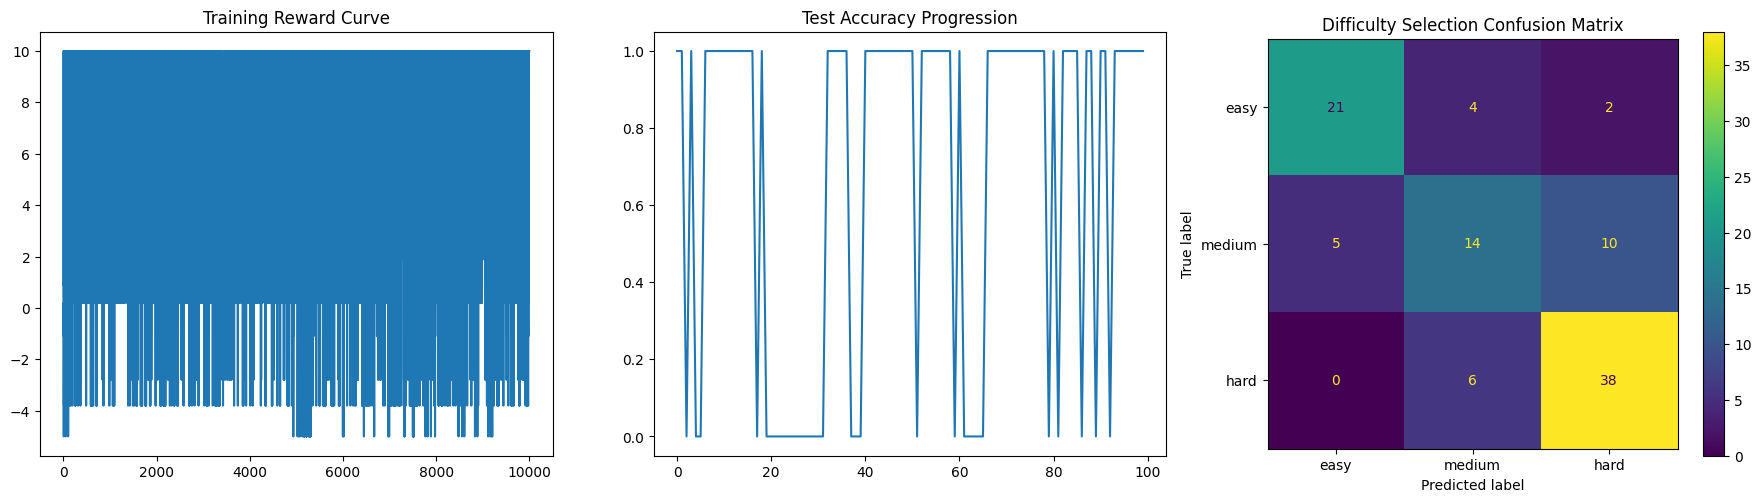

Confusion Matrix:
 [[21  4  2]
 [ 5 14 10]
 [ 0  6 38]]


In [ ]:
# CELL 10: Plotting Evaluation Matrices
plt.figure(figsize=(18,5))

# Reward Curve
plt.subplot(1,3,1)
plt.plot(episode_rewards)
plt.title("Training Reward Curve")

# Accuracy Progression
plt.subplot(1,3,2)
plt.plot(test_learner.accuracy_history)
plt.title("Test Accuracy Progression")

# Confusion Matrix
plt.subplot(1,3,3)
def oracle(p):
    return "easy" if p=="low" else "medium" if p=="medium" else "hard"

cm = confusion_matrix(
    [oracle(p) for p in test_states],
    test_actions,
    labels=["easy","medium","hard"]
)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["easy", "medium", "hard"])
disp.plot(ax=plt.gca())

plt.title("Difficulty Selection Confusion Matrix")

plt.tight_layout()
plt.show()

print("Confusion Matrix:\n", cm)

Saving Model and Results

In [ ]:
import os

SAVE_DIR = "/content/saved_models1"
os.makedirs(SAVE_DIR, exist_ok=True)


In [ ]:
MODEL_PATH = os.path.join(SAVE_DIR, "dqn_policy_net.pth")

torch.save(policy_net.state_dict(), MODEL_PATH)

print("Model saved at:", MODEL_PATH)


Model saved at: /content/saved_models1/dqn_policy_net.pth


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
SAVE_DIR = "/content/drive/MyDrive/RL_Adaptive_Learning1/models"
os.makedirs(SAVE_DIR, exist_ok=True)


In [ ]:
MODEL_PATH = os.path.join(SAVE_DIR, "dqn_policy_net.pth")
torch.save(policy_net.state_dict(), MODEL_PATH)


In [ ]:
torch.save({
    "policy_net": policy_net.state_dict(),
    "target_net": target_net.state_dict(),
    "optimizer": optimizer.state_dict(),
    "episode": num_episodes
}, os.path.join(SAVE_DIR, "dqn_checkpoint.pth"))


In [ ]:
MODEL_PATH = os.path.join(SAVE_DIR, "dqn_checkpoint.pth")
torch.save(policy_net.state_dict(), MODEL_PATH)


In [ ]:
torch.save({
    "model_state_dict": policy_net.state_dict(),
    "state_dim": 8,
    "action_dim": 3,
    "reward_version": "v3-balanced",
    "date": "2026-01-02"
}, os.path.join(SAVE_DIR, "adaptive_dqn_final.pth"))


In [ ]:
MODEL_PATH = os.path.join(SAVE_DIR, "adaptive_dqn_final.pth")
torch.save(policy_net.state_dict(), MODEL_PATH)


In [ ]:
import os
import json
import numpy as np

BASE_DIR = "/content/drive/MyDrive/RL_Adaptive_Learning1"
RESULTS_DIR = os.path.join(BASE_DIR, "results")
MODELS_DIR = os.path.join(BASE_DIR, "models")

os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)


In [ ]:
# Save reward history
np.save(os.path.join(RESULTS_DIR, "episode_rewards.npy"),
        np.array(episode_rewards))

# Save test accuracy
np.save(os.path.join(RESULTS_DIR, "test_accuracy.npy"),
        np.array(test_learner.accuracy_history))


In [ ]:
plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["easy","medium","hard"])
disp.plot(cmap="viridis", ax=plt.gca())
plt.title("Difficulty Selection Confusion Matrix")

plt.savefig(os.path.join(RESULTS_DIR, "confusion_matrix.png"),
            dpi=200, bbox_inches="tight")
plt.close()


In [ ]:
# Reward curve
plt.figure()
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Training Reward Curve")
plt.savefig(os.path.join(RESULTS_DIR, "reward_curve.png"),
            dpi=200, bbox_inches="tight")
plt.close()

# Accuracy curve
plt.figure()
plt.plot(test_learner.accuracy_history)
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.title("Test Accuracy Progression")
plt.savefig(os.path.join(RESULTS_DIR, "accuracy_curve.png"),
            dpi=200, bbox_inches="tight")
plt.close()


Changing Compute_reward to optimize the confusion matrix

In [ ]:
def compute_reward(correct, proficiency, difficulty, conceptual_score):
    reward = 2.0 if correct else -2.0

    prof_map = {"low":0, "medium":1, "high":2}
    diff_map = {"easy":0, "medium":1, "hard":2}

    diff_gap = diff_map[difficulty] - prof_map[proficiency]

    # Penalty/reward for difficulty mismatch
    if diff_gap > 0:  # too hard
        reward -= 2.0 * diff_gap  # Increased penalty from 1.0 to 2.0
    elif diff_gap < 0:  # too easy
        reward -= 1.0 * abs(diff_gap) # Increased penalty from 0.5 to 1.0
    else:
        reward += 2.0  # Increased matched difficulty bonus from 1.0 to 2.0

    # Bonus for conceptual score
    reward += max(min(conceptual_score,1.0),0.0)

    # Extra bonus if high proficiency student gets hard question correct
    if proficiency == "high" and difficulty == "hard" and correct:
        reward += 8.0 # Retained at 8.0

    # Add a specific bonus for 'medium' proficiency and 'medium' difficulty if correct
    if proficiency == "medium" and difficulty == "medium" and correct:
        reward += 8.0  # Retained at 8.0

    # Clip reward - Upper limit confirmed at 10.0
    reward = max(min(reward,10.0), -5.0)
    return reward

In [ ]:
test_learner = LearnerModel()
test_actions = []
test_states = []
test_rewards = []
for _ in range(5):  # 5 test students
    test_learner = LearnerModel()
    test_actions = []
    test_states = []
    for _ in range(100):
        state = test_learner.get_state()
        with torch.no_grad():
            action = torch.argmax(policy_net(state)).item()
        difficulty = ["easy","medium","hard"][action]
        q = select_question(difficulty)
        ans = student_answer(q, test_learner.proficiency)
        correct, _ = evaluate_answer(q, ans)
        test_learner.update(correct, difficulty)
        test_actions.append(difficulty)
        test_states.append(test_learner.proficiency)
    test_rewards.append(np.mean(test_learner.accuracy_history))
print("Avg test accuracy:", np.mean(test_rewards))

Avg test accuracy: 0.7899999999999998


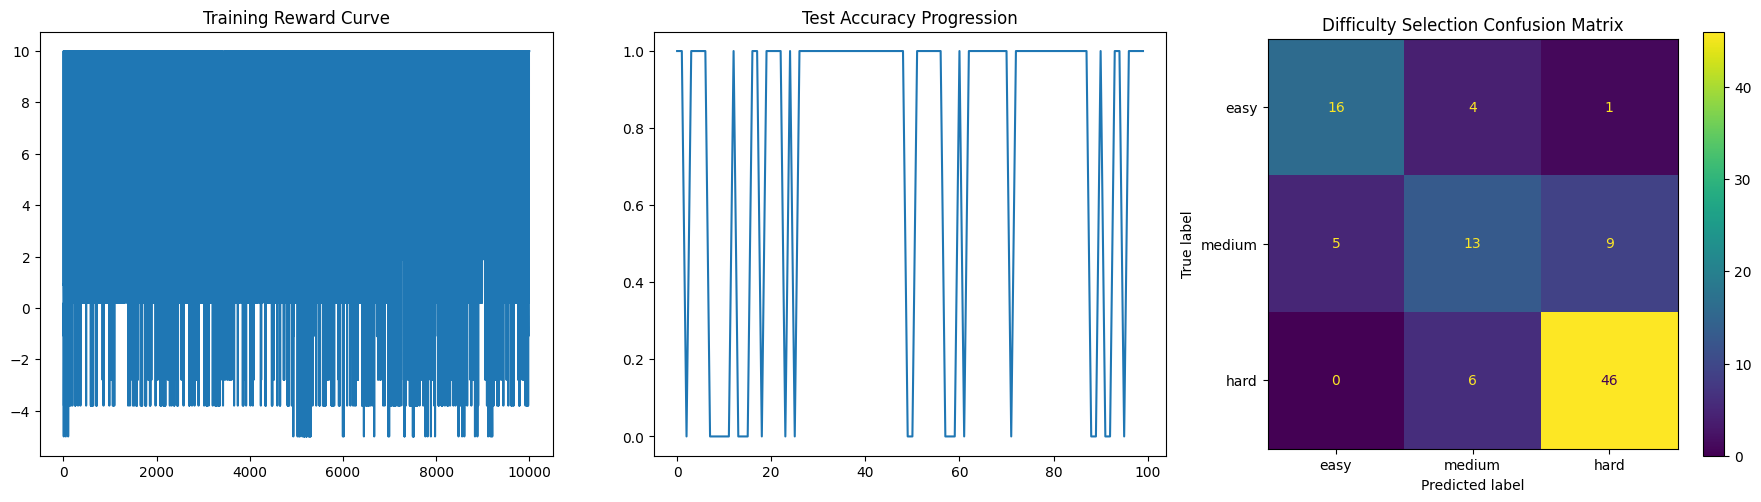

Confusion Matrix:
 [[16  4  1]
 [ 5 13  9]
 [ 0  6 46]]


In [ ]:
plt.figure(figsize=(18,5))

# Reward Curve
plt.subplot(1,3,1)
plt.plot(episode_rewards)
plt.title("Training Reward Curve")

# Accuracy Progression
plt.subplot(1,3,2)
plt.plot(test_learner.accuracy_history)
plt.title("Test Accuracy Progression")

# Confusion Matrix
plt.subplot(1,3,3)
def oracle(p):
    return "easy" if p=="low" else "medium" if p=="medium" else "hard"

cm = confusion_matrix(
    [oracle(p) for p in test_states],
    test_actions,
    labels=["easy","medium","hard"]
)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["easy", "medium", "hard"])
disp.plot(ax=plt.gca())

plt.title("Difficulty Selection Confusion Matrix")

plt.tight_layout()
plt.show()

print("Confusion Matrix:\n", cm)

# Inferencing or Simlating Student Rsponse for Showing the output

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
import pandas as pd
import torch.nn as nn

# --- Start of self-contained definitions ---

# Reproducibility (copied from CELL 1)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Generating and saving sample questions (copied from CELL 2)
BASE_QUESTIONS = [
    ("easy",
     "Which term is zero in steady-state mass balance?",
     ["Input", "Output", "Accumulation", "Generation"],
     2, "mass_balance"),

    ("medium",
     "Why is a purge stream required in recycle systems?",
     ["Increase conversion", "Remove inert accumulation",
      "Reduce pressure", "Increase recycle ratio"],
     1, "recycle_systems"),

    ("hard",
     "Which balance must always be satisfied?",
     ["Component balance", "Energy balance",
      "Overall mass balance", "Entropy balance"],
     2, "conservation_laws")
]

rows = []
qid = 1

for i in range(350):  # ~1050 questions
    for diff, q, opts, ans, concept in BASE_QUESTIONS:
        rows.append({
            "id": qid,
            "difficulty": diff,
            "question": f"{q} (Variant {i+1})",
            "option_a": opts[0],
            "option_b": opts[1],
            "option_c": opts[2],
            "option_d": opts[3],
            "answer": ans,
            "concept": concept
        })
        qid += 1

df_questions = pd.DataFrame(rows)
# Ensure the directory exists before saving
if not os.path.exists('/content'):
    os.makedirs('/content')
df_questions.to_csv("/content/question_bank.csv", index=False)

# Loding Questions (copied from CELL 3)
df_loaded = pd.read_csv("/content/question_bank.csv")

QUESTION_BANK = {"easy": [], "medium": [], "hard": []}

for _, row in df_loaded.iterrows():
    QUESTION_BANK[row["difficulty"]].append({
        "id": row["id"],
        "question": row["question"],
        "options": [
            row["option_a"],
            row["option_b"],
            row["option_c"],
            row["option_d"]
        ],
        "answer": int(row["answer"]),
        "concept": row["concept"]
    })

# Setting LearnerModel (copied from CELL 5)
class LearnerModel:
    def __init__(self):
        self.accuracy_history = []
        self.recent_results = []
        self.recent_difficulties = []
        self.proficiency = "medium"

    def update(self, correct, difficulty):
        self.accuracy_history.append(correct)
        self.recent_results.append(correct)
        self.recent_difficulties.append(difficulty)

        if len(self.recent_results) > 20:
            self.recent_results.pop(0)
        if len(self.recent_difficulties) > 20:
            self.recent_difficulties.pop(0)

        self._update_proficiency()

    def _update_proficiency(self):
        if len(self.recent_results) < 3:
            return
        avg = np.mean(self.recent_results[-3:])
        if avg >= 0.75:
            self.proficiency = "high"
        elif avg >= 0.45:
            self.proficiency = "medium"
        else:
            self.proficiency = "low"

    def get_state(self):
        prof_map = {"low": 0.0, "medium": 0.5, "high": 1.0}
        accuracy = np.mean(self.accuracy_history[-5:]) if self.accuracy_history else 0.5
        trend = np.mean(self.recent_results[-3:]) if len(self.recent_results) >= 3 else 0.5
        hard_ratio = self.recent_difficulties.count("hard") / len(self.recent_difficulties) if self.recent_difficulties else 0.0
        easy_ratio = self.recent_difficulties.count("easy") / len(self.recent_difficulties) if self.recent_difficulties else 0.0

        # Difficulty-specific recent accuracy
        easy_acc = np.mean([r for r,d in zip(self.recent_results, self.recent_difficulties) if d=='easy'] or [0])
        medium_acc = np.mean([r for r,d in zip(self.recent_results, self.recent_difficulties) if d=='medium'] or [0])
        hard_acc = np.mean([r for r,d in zip(self.recent_results, self.recent_difficulties) if d=='hard'] or [0])

        # Final state vector
        state = [prof_map[self.proficiency], accuracy, trend, hard_ratio, easy_ratio, easy_acc, medium_acc, hard_acc]
        return torch.tensor(state, dtype=torch.float32)

# Introducing Deep-Q Network (copied from CELL 6)
class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(8, 128),  # <-- change input size from 5 -> 8
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 3)  # 3 actions: easy/medium/hard
        )

    def forward(self, x):
        return self.net(x)

# Emulate student response (copied from CELL 6)
def select_question(difficulty):
    return random.choice(QUESTION_BANK[difficulty])

def student_answer(question, proficiency):
    prob = {"low": 0.3, "medium": 0.6, "high": 0.85}
    if random.random() < prob[proficiency]:
        return question["answer"]
    return random.randint(0, len(question["options"]) - 1)

def evaluate_answer(question, student_ans):
    correct = int(student_ans == question["answer"])
    conceptual_score = 0.9 if correct else 0.2
    return correct, conceptual_score

# --- End of self-contained definitions ---

# Define the path where the model was saved
SAVE_DIR = "/content/drive/MyDrive/RL_Adaptive_Learning1/models"
MODEL_PATH = os.path.join(SAVE_DIR, "adaptive_dqn_final.pth")

# Instantiate a new DQN model
loaded_policy_net = DQN()

# Load the saved state dictionary
# Note: The model was saved as policy_net.state_dict() directly.
loaded_policy_net.load_state_dict(torch.load(MODEL_PATH))
loaded_policy_net.eval() # Set the model to evaluation mode

print(f"Model loaded successfully from: {MODEL_PATH}")

# --- Interactive Simulation with Loaded Model ---

# Initialize a learner for interaction
interactive_learner = LearnerModel()

print("\n--- Interactive Learning Simulation ---")
print(f"Initial learner proficiency: {interactive_learner.proficiency}")

num_interaction_steps = 10 # You can change this to simulate more interactions

for i in range(num_interaction_steps):
    current_state = interactive_learner.get_state()

    with torch.no_grad():
        action = torch.argmax(loaded_policy_net(current_state)).item()

    recommended_difficulty = ["easy","medium","hard"][action]

    print(f"\nStep {i+1}:")
    print(f"  Current Learner Proficiency: {interactive_learner.proficiency}")
    print(f"  Model Recommends Difficulty: {recommended_difficulty}")

    # Simulate student answering a question of the recommended difficulty
    question = select_question(recommended_difficulty)
    student_response = student_answer(question, interactive_learner.proficiency)
    is_correct, _ = evaluate_answer(question, student_response)

    print(f"  (Simulated student answered {'Correctly' if is_correct else 'Incorrectly'})")

    # Update learner model based on the simulated response
    interactive_learner.update(is_correct, recommended_difficulty)

    print(f"  New Learner Proficiency: {interactive_learner.proficiency}")

print("\n--- Simulation Complete ---")
print(f"Final learner proficiency: {interactive_learner.proficiency}")
print(f"Overall accuracy during simulation: {np.mean(interactive_learner.accuracy_history):.2f}")

Model loaded successfully from: /content/drive/MyDrive/RL_Adaptive_Learning1/models/adaptive_dqn_final.pth

--- Interactive Learning Simulation ---
Initial learner proficiency: medium

Step 1:
  Current Learner Proficiency: medium
  Model Recommends Difficulty: hard
  (Simulated student answered Correctly)
  New Learner Proficiency: medium

Step 2:
  Current Learner Proficiency: medium
  Model Recommends Difficulty: hard
  (Simulated student answered Correctly)
  New Learner Proficiency: medium

Step 3:
  Current Learner Proficiency: medium
  Model Recommends Difficulty: hard
  (Simulated student answered Incorrectly)
  New Learner Proficiency: medium

Step 4:
  Current Learner Proficiency: medium
  Model Recommends Difficulty: hard
  (Simulated student answered Correctly)
  New Learner Proficiency: medium

Step 5:
  Current Learner Proficiency: medium
  Model Recommends Difficulty: hard
  (Simulated student answered Correctly)
  New Learner Proficiency: medium

Step 6:
  Current Learn

## Ethical Considerations & Responsible AI

Ethical responsibility plays an important role in the development of AI-based personalized learning systems. Bias and fairness are addressed by ensuring that learning recommendations are based only on student performance indicators such as accuracy, progress, and response time, rather than personal or demographic attributes. This approach helps reduce unfair treatment and ensures that personalization focuses on academic needs. Continuous learning from user feedback further helps the system adapt over time and minimizes the risk of long-term bias.

The system’s performance is influenced by the quality and diversity of the training data. Limited or simulated datasets may not fully represent real student behavior, which can affect the accuracy of recommendations. To reduce this limitation, the system is designed to improve gradually through real user interactions. Responsible use of AI is maintained by treating the system as a support tool rather than a replacement for teachers. Local model deployment is preferred to protect user data and ensure privacy, while transparency about system limitations helps promote ethical and informed use.

## Conclusion & Future Scope

This project presents a personalized learning system that uses reinforcement learning and natural language processing to adapt educational content based on individual student performance. The system models learning as a sequential decision-making process, allowing it to adjust difficulty levels, topic selection, and feedback dynamically. The results show that such an adaptive approach can improve learner engagement and provide more effective learning support compared to static methods.

Future improvements may include the use of more advanced reinforcement learning algorithms to enhance scalability and stability. Incorporating real-world classroom data and additional learner interaction signals could further improve personalization accuracy. The system can also be extended with explainable AI features to make its recommendations easier to understand, increasing trust and usability in practical educational settings.